In [1]:
# Author: Brent Artuch
# Date: 2024-10-07

import sympy as sp
from sympy.physics.quantum import *
import numpy as np

# Qiskit and Q# libraries
import qsharp
from qsharp_widgets import Circuit
from qiskit.quantum_info import Operator, Statevector
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

sp.init_printing()

## Bell States
The collection of all four Bell states is known as the Bell basis; all four of the Bell states represent entanglement between two qubits.
\begin{align*}
\ket{\beta_{00}}=\ket{\Phi^+}=\frac{1}{\sqrt{2}}(\ket{00}+\ket{11})=CNOT(H)\ket{0}\ket{0}\\
\ket{\beta_{10}}=\ket{\Phi^-}=\frac{1}{\sqrt{2}}(\ket{00}-\ket{11})=CNOT(H)\ket{1}\ket{0}\\
\ket{\beta_{01}}=\ket{\Psi^+}=\frac{1}{\sqrt{2}}(\ket{01}+\ket{10})=CNOT(H)\ket{0}\ket{1}\\
\ket{\beta_{11}}=\ket{\Psi^-}=\frac{1}{\sqrt{2}}(\ket{01}-\ket{10})=CNOT(H)\ket{1}\ket{1}\\
\end{align*}
These states can also be derived from the formula:<br>
\begin{align*}
\ket{\beta_{x,y}}=\frac{1}{\sqrt{2}}\left(\ket{0,y}+(-1)^x\ket{1,\neg y}\right)
\end{align*}

In [2]:
# Define |0> and |1>
ket_zero = Statevector([1, 0]) 
ket_one = Statevector([0, 1]) 

# Define H and CNOT gates
H = Operator([[1 / np.sqrt(2), 1 / np.sqrt(2)], [1 / np.sqrt(2), -1 / np.sqrt(2)]])
CX = Operator([
 [1, 0, 0, 0],
 [0, 1, 0, 0],
 [0, 0, 0, 1],
 [0, 0, 1, 0]])

# Plus and minus states
ket_plus = ket_zero.evolve(H)
ket_minus = ket_one.evolve(H)

# Evaluate tensor products
ket_plus_zero = ket_plus.tensor(ket_zero)
ket_minus_zero = ket_minus.tensor(ket_zero)
ket_plus_one = ket_plus.tensor(ket_one)
ket_minus_one = ket_minus.tensor(ket_one)

# Apply the CNOT gate
phi_plus = ket_plus_zero.evolve(CX)
phi_minus = ket_minus_zero.evolve(CX)
psi_plus = ket_plus_one.evolve(CX)
psi_minus = ket_minus_one.evolve(CX)

bell_states = [phi_plus,phi_minus,psi_plus,psi_minus]

for state in bell_states:
    display(state.draw("latex"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

We can express the Bell States as computational basis vectors of 2-qubit systems, or indeed any complex vector at all having entries corresponding to the four classical states of two bits, can be expressed as a linear combination of the four Bell states. For example, let's find $\ket{00}$ in the Bell Basis:<br>
\begin{align*}
\ket{\Phi^+}&=\frac{1}{\sqrt{2}}(\ket{00}+\ket{11})\\
\ket{\Phi^+}&=\frac{1}{\sqrt{2}}\ket{00}+\frac{1}{\sqrt{2}}\ket{11}\\
-1( -\frac{1}{\sqrt{2}}\ket{00}&=\frac{1}{\sqrt{2}}\ket{11}-\ket{\Phi^+})\\
\frac{1}{\sqrt{2}}\ket{00}&=\ket{\Phi^+}-\frac{1}{\sqrt{2}}\ket{11}\\
\sqrt{2}\ket{00}&=\ket{\Phi^+}+\frac{1}{\sqrt{2}}\ket{00}-\frac{1}{\sqrt{2}}\ket{11}\\
\ket{00}&=\ket{\Phi^+}+\ket{\Phi^-}\\
\ket{00}&=\frac{1}{\sqrt{2}}\ket{\Phi^+}+\frac{1}{\sqrt{2}}\ket{\Phi^-}\\
\end{align*}
The four Z-basis states in terms of the Bell Basis:<br>
\begin{align*}
\ket{00}&=\frac{1}{\sqrt{2}}\ket{\Phi^+}+\frac{1}{\sqrt{2}}\ket{\Phi^-}\\
\ket{01}&=\frac{1}{\sqrt{2}}\ket{\Psi^+}+\frac{1}{\sqrt{2}}\ket{\Psi^-}\\
\ket{10}&=\frac{1}{\sqrt{2}}\ket{\Psi^+}-\frac{1}{\sqrt{2}}\ket{\Psi^-}\\
\ket{11}&=\frac{1}{\sqrt{2}}\ket{\Phi^+}-\frac{1}{\sqrt{2}}\ket{\Phi^-}\\
\end{align*}

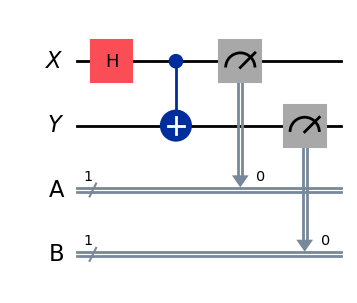

In [3]:
# Circuit representation for formulation of the Bell States
# Define control and target
X = QuantumRegister(1, "X")
Y = QuantumRegister(1, "Y")
# Define clssical bits for measurement results
A = ClassicalRegister(1, "A")
B = ClassicalRegister(1, "B")

# Apply H gate to control and then CNOT 
circuit = QuantumCircuit(X, Y, A, B)
circuit.h(X)
circuit.cx(X, Y)

# Measurement
circuit.measure(X, A)
circuit.measure(Y, B)

display(circuit.draw("mpl"))

## Teleportation
There are two individuals named Alice and Bob. Alice is on the surface and Bob is on an orbiting satalite. Alice has two qubits $A$ and $C$ and Bob has a qubit $B$. $\alpha$ and $\beta$ are unknown to Alice. Alice can only coommunicate with Bob via classical information. To deliver $C$ to Bob. If they share a pair of entangled qubits in the state $A=B=\ket{\Phi^+}$, Alice can transfer $C$ to Bob in terms of $A$:<br>
\begin{align*}
\ket{\psi}\ket{\Phi^+}&=\alpha\ket{0}\ket{\Phi^+}+\beta\ket{1}\ket{\Phi^+}\\
&=\alpha\ket{0}\frac{1}{\sqrt{2}}(\ket{00}+\ket{11})+\beta\ket{1}\frac{1}{\sqrt{2}}(\ket{00}+\ket{11})\\
&=\frac{1}{\sqrt{2}}[\alpha(\ket{000}+\ket{011})+\beta(\ket{100}+\ket{111})]\\
\end{align*}
The left two qubits belong to Alice and the right qubit to Bob ST the basis vectors are $\ket{CAB}$. Now, Alice can apply the CNOT and H gates:<br>
\begin{align*}
\ket{\psi}\ket{\Phi^+}&=H_{C}(CNOT_{CA})\left[\frac{1}{\sqrt{2}}[\alpha(\ket{000}+\ket{011})+\beta(\ket{100}+\ket{111})]\right]\\
&=H_{C}\left[\frac{1}{\sqrt{2}}[\alpha(\ket{000}+\ket{011})+\beta(\ket{110}+\ket{101})]\right]\\
&=\frac{1}{\sqrt{2}}[\alpha(\ket{+00}+\ket{+11})+\beta(\ket{-10}+\ket{-01})]\\
&=\frac{1}{2}[\alpha(\ket{0}+\ket{1})(\ket{00}+\ket{11})+\beta(\ket{0}-\ket{1})(\ket{10}+\ket{01})]\\
&=\frac{1}{2}[\ket{00}(\alpha\ket{0}+\beta\ket{1})+\ket{01}(\beta\ket{0}+\alpha\ket{1})+\ket{10}(\alpha\ket{0}-\beta\ket{1})+\ket{11}(-\beta\ket{0}+\alpha\ket{1})]\\
\end{align*}
After measurement, the possible states are:<br>
\begin{align*}
&\ket{00}(\alpha\ket{0}+\beta\ket{1})\\
&\ket{01}(\beta\ket{0}+\alpha\ket{1})\\
&\ket{10}(\alpha\ket{0}-\beta\ket{1})\\
&\ket{11}(-\beta\ket{0}+\alpha\ket{1})
\end{align*}
Now Bob Can apply gates to his qubit $B$ to match $C$ depending on the result of Alice's measurement:<br>
* If Alice measures $\ket{00}$, Bob does nothing to $B$ because it is already in the state $\ket{\psi}$
* If Alice measures $\ket{01}$, Bob applies the $X$ gate to $B$ transforming it into $\ket{\psi}$
* If Alice measures $\ket{10}$, Bob applies the $Z$ gate to $B$ transforming it into $\ket{\psi}$
* If Alice measures $\ket{11}$, Bob applies the $X$ gate followed by the $Z$ gate to $B$ transforming it into $\ket{\psi}$

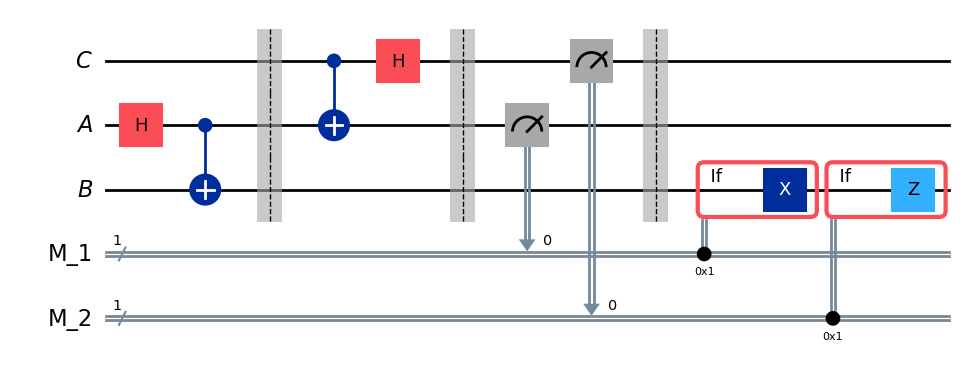

In [9]:
# Circuit Diagram
# Define qubits
C = QuantumRegister(1, "C")
A = QuantumRegister(1, "A")
B = QuantumRegister(1, "B")
a = ClassicalRegister(1, "M_1")
b = ClassicalRegister(1, "M_2")

# Define Circuit
teleportation_circuit = QuantumCircuit(C, A, B, a, b)

# Prepare ebit used for teleportation
teleportation_circuit.h(A)
teleportation_circuit.cx(A, B)
teleportation_circuit.barrier()

# Alice's operations
teleportation_circuit.cx(C, A)
teleportation_circuit.h(C)
teleportation_circuit.barrier()

# Alice measures and sends classical bits to Bob
teleportation_circuit.measure(A, a)
teleportation_circuit.measure(C, b)
teleportation_circuit.barrier()

# Bob uses the classical bits to conditionally apply gates
with teleportation_circuit.if_test((a, 1)):
    teleportation_circuit.x(B)
with teleportation_circuit.if_test((b, 1)):
    teleportation_circuit.z(B)

display(teleportation_circuit.draw("mpl"))

Simple Q# program for measuring a single qubit and then resetting it

In [5]:
%%qsharp

// Open the namespace for the MResetZ operation.
import Microsoft.Quantum.Measurement;

@EntryPoint()
operation MeasureOneQubit() : Result {
    // Allocate a qubit. By default, it's in the 0 state.      
    use q = Qubit();  
    // Apply the Hadamard operation, H, to the state.
    // It now has a 50% chance of being measured as 0 or 1. 
    H(q);  
    // Measure and reset the qubit, and then return the result value.
    return MResetZ(q);
}

MeasureOneQubit()

One

In [6]:
# Circuit diagram
qsharp.circuit("MeasureOneQubit()")

q_0    ── H ──── M ─── |0〉 ─
                 ╘══════════

Q# program for entangling two qubits into a bell state:

In [7]:
%%qsharp

import Std.Diagnostics.*;
        
@EntryPoint()
operation EntangleQubits() : (Result, Result) {  
    // Allocate two qubits, q1 and q2, in the 0 state.
    use (q1, q2) = (Qubit(), Qubit());

    // Put q1 into an even superposition.
    // It now has a 50% chance of being measured as 0 or 1.
    H(q1);

    // Entangle q1 and q2, making q2 depend on q1.
    CNOT(q1, q2);

    // Show the entangled state of the qubits.
    DumpMachine();

    // Measure q1 and q2 and store the results in m1 and m2.
    let (m1, m2) = (M(q1), M(q2));

    // Reset q1 and q2 to the 0 state.
    Reset(q1);
    Reset(q2);

    // Return the measurement results.
    return (m1, m2);
}

EntangleQubits()

<table class="qs-stateTable">
  <style>
    .qs-stateTable thead tr {
      background-color: var(
        --vscode-list-hoverBackground,
        var(--jp-layout-color1, inherit)
      );
    }
    .qs-stateTable th {
      text-align: left;
      border: none;
    }
    .qs-stateTable tbody {
      pointer-events: none;
    }
    .qs-stateTable tbody td {
      text-align: left;
      border: none;
    }
    .qs-stateTable tbody td span {
      display: inline-block;
    }
    .qs-stateTable tbody tr:nth-child(even) {
      background-color: var(
        --vscode-list-hoverBackground,
        var(--jp-layout-color1, inherit)
      );
    }
  </style>
  <thead>
    <tr>
      <th>Basis State<br />(|𝜓₁…𝜓ₙ⟩)</th>
      <th>Amplitude</th>
      <th>Measurement Probability</th>
      <th colspan="2">Phase</th>
    </tr>
  </thead>
  <tbody>
    <tr>
  <td>
    <span>|00⟩</span>
  </td>
  <td>
    <span>0.7071+0.0000𝑖</span>
  </td>
  <td>
    <progress max="100" value="50.000000000000014"></progress>
    <span>50.0000%</span>
  </td>
  <td style="transform: rotate(0.0000rad)">↑</td>
  <td>
    <span>0.0000</span>
  </td>
</tr>
<tr>
  <td>
    <span>|11⟩</span>
  </td>
  <td>
    <span>0.7071+0.0000𝑖</span>
  </td>
  <td>
    <progress max="100" value="50.000000000000014"></progress>
    <span>50.0000%</span>
  </td>
  <td style="transform: rotate(0.0000rad)">↑</td>
  <td>
    <span>0.0000</span>
  </td>
</tr>

  </tbody>
</table>


$|\psi\rangle = \frac{\sqrt{2}}{2}|00\rangle+\frac{\sqrt{2}}{2}|11\rangle$

(Zero, Zero)

In [8]:
# Circuit diagram
qsharp.circuit("EntangleQubits()")

q_0    ── H ──── ● ──── M ─── |0〉 ─
                 │      ╘══════════
q_1    ───────── X ──── M ─── |0〉 ─
                        ╘══════════